In [1]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(foreach)
    library(doParallel)
    library(GenomicRanges)
    library(rtracklayer)
    library(limma)
    library(matrixStats)
});
registerDoParallel(6);

options(repr.plot.width=4, repr.plot.height=2, jupyter.plot_mimetypes = "image/svg+xml", digits=3);
theme_set(theme_classic(base_family = "Lucida Sans"));
mycols = c('gray', 'forestgreen', 'firebrick');

In [ ]:
# this function will merge (add) metadata columns for
# identical reads. used to bin data (if desired)
collapse_reads = function( x ) {
  u = x[!duplicated(x)];
  x = x[ duplicated(x)];
  gc();
  for( cn in 1:ncol(mcols(u)) ) {
    z = x[ mcols(x)[,cn]>0 ];
    hits = findOverlaps( u, z, type="equal" );
    if( any(duplicated(hits@from)) ) {
        hits = aggregate( mcols(z)[hits@to,cn] ~ hits@from, FUN='sum' );
        mcols(u)[hits[,1],cn] = mcols(u)[hits[,1],cn] + hits[,2];
    } else {
        mcols(u)[hits@from,cn] = mcols(u)[hits@from,cn] + mcols(z)[hits@to,cn];
    }
  }
  return(u);
}

In [2]:
# load HiDRA data and filter
load("./data/HiDRA.Rdata");
HiDRA = HiDRA[!seqnames(HiDRA) %in% c("chrX", "chrY", "chrM")];
HiDRA = HiDRA[ width(HiDRA) >= 100 & width(HiDRA) <= 600 ];

# bin to 10bp resolution
#start(HiDRA) = 10 * as.integer(start(HiDRA) / 10)+1;
#  end(HiDRA) = 10 * as.integer(  end(HiDRA) / 10)+1;
# sapply(mcols(HiDRA), "sum");
# HiDRA = collapse_reads(HiDRA);
totReads = sapply(mcols(HiDRA), sum);
totReads

DNA1     DNA2     DNA3     DNA4     DNA5     RNA1     RNA2     RNA3 
76760444 57039228 57472069 60926064 58688152 61997162 61191059 63298711 
    RNA4     RNA5 
62495604 62350786

In [4]:
# normalize DNA and RNA replicates to same total count
normF = unname(1E8 / totReads);
mcols(HiDRA) = t( normF * t(as.matrix(mcols(HiDRA))) );
sapply(mcols(HiDRA), sum);

# Require at least 7 total DNA counts across all reps
summary(HiDRA$DNA1 + HiDRA$DNA2 + HiDRA$DNA3 + HiDRA$DNA4 + HiDRA$DNA5);
HiDRA = HiDRA[ HiDRA$DNA1 + HiDRA$DNA2 + HiDRA$DNA3 + HiDRA$DNA4 + HiDRA$DNA5 >= 7 ];
gc();
length(HiDRA)

DNA1  DNA2  DNA3  DNA4  DNA5  RNA1  RNA2  RNA3  RNA4  RNA5 
1e+08 1e+08 1e+08 1e+08 1e+08 1e+08 1e+08 1e+08 1e+08 1e+08

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0      17      38      47      66   15968 

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6.73e+06,360,1.25e+07,670,8.87e+06,474
Vcells,1.15e+08,878,4.35e+08,3321,5.44e+08,4150


[1] 9031829

In [5]:
# analyze fragments in 50 bp groups to minimize size bias
# apply voom model : RNA vs DNA
frags = HiDRA;
# type = RNA or DNA
# repn = rep number (blocking variable)
coldata = data.frame( type=substr(colnames(mcols(frags)), 1, 3), repn=1:5 );
mdes=model.matrix(~type, data=coldata);

HiDRA = foreach( w = 50*(2:11), .combine='append' ) %do% {
    chunk = frags[width(frags) >= w & width(frags) < (w+50)];
    message(paste("width =", w, ",", length(chunk), "fragments"));
    frags = frags[width(frags) >= w+50];
    hcounts = as.matrix(mcols(chunk));
    mcols(chunk) = NULL;
    
    vdata = voomWithQualityWeights(hcounts, design=mdes, plot=F);
    vcorrf = duplicateCorrelation(vdata, mdes, block = coldata$repn)$consensus.correlation;
    fit = eBayes( lmFit(vdata, mdes, block = coldata$repn, correlation = vcorrf) );
    hits = topTable(fit, coef='typeRNA', number=Inf, sort.by = "none");
    chunk$p = hits$adj.P.Val;
    chunk$Ratio = hits$logFC;
    return(chunk);
};

sum(HiDRA$p < sqrt(0.05));
HiDRA = sort(HiDRA);
save(HiDRA, file="./data/HiDRA_voom.Rdata");

width = 100 , 5037 fragments
width = 150 , 343401 fragments
width = 200 , 1556745 fragments
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”width = 250 , 1145961 fragments
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance not achievable”width = 300 , 1373131 fragments
Warning message in glmgam.fit(dx, dy, coef.start = start, tol = tol, maxit = maxit, :
“Too much damping - convergence tolerance n

[1] 738364

Warning message in mean.default(HiDRA$logFC[HiDRA$p < 0.1]):
“argument is not numeric or logical: returning NA”

[1] NA

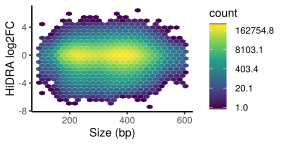

In [6]:
out = data.frame( Size=width(HiDRA), logFC=HiDRA$Ratio );
mean(HiDRA$logFC[HiDRA$p < 0.1])
print(
    ggplot(out, aes(Size, logFC)) +
    xlab("Size (bp)") +
    ylab("HiDRA log2FC") +
    geom_hex(bins=24) +
    scale_fill_viridis_c(trans="log")
);
#ggsave("./HiDRA_SizeBias.pdf", width=4, height=2);